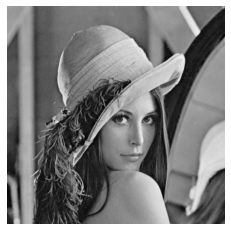

In [2]:
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('Image/lena.bmp').convert('L')
img = np.array(img)

plt.axis('off')
plt.imshow(img, cmap = 'gray')

In [1]:
# 1. Design the edge detection system

def filtering(img, filter):   # convolution
    h, w = img.shape
    fSize = len(filter)       # filter Size
    pSize = (fSize-1) // 2    # padding Size
    
    img = np.pad(img, ((pSize,pSize),(pSize,pSize)), 'constant', constant_values=0)
    filteredImg = np.zeros((h,w))
    
    for i in range(pSize,h+pSize):      # operate on ground-truth pixel
        for j in range(pSize,w+pSize):
            product = img[i-pSize:i+pSize+1,j-pSize:j+pSize+1] * filter
            filteredImg[i-pSize][j-pSize] = product.sum()
            
    return filteredImg

def sobelEdgeDetection(img):
    threshold = 150
    mx = [ [-1,0,1],
           [-2,0,2],
           [-1,0,1] ]
    my = [ [-1,-2,-1],
           [ 0, 0, 0],
           [ 1, 2, 1] ]
    
    dx = filtering(img,mx)
    dy = filtering(img,my)
    s = np.sqrt(dx**2 + dy**2)  #strength
    o = np.arctan2(dx, dy)      #orientation
    f = s                       #final
    f[ f>=threshold ] = 255
    f[ f<threshold ] = 0
    return dx, dy, s, o, f

dx,dy,s,o,f  = sobelEdgeDetection(img)

plt.figure(figsize=(30,20))
plt.subplot(2,3,1)
plt.axis('off')
plt.title('dx')
plt.imshow(dx, cmap='gray')
plt.subplot(2,3,2)
plt.axis('off')
plt.title('dy')
plt.imshow(dy, cmap='gray')
plt.subplot(2,3,3)
plt.axis('off')
plt.title('strength')
plt.imshow(s, cmap='gray')
plt.subplot(2,3,4)
plt.axis('off')
plt.title('edge orientation')
plt.imshow(o, cmap='gray')
plt.subplot(2,3,5)
plt.axis('off')
plt.title('final edge')
plt.imshow(f, cmap='gray')

NameError: name 'img' is not defined

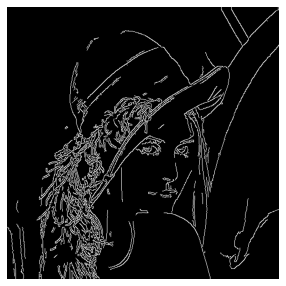

In [3]:
# 2. Canny edge detector.  
# non maximum suppression이 수행되었기 때문에 edge가 얇음
import cv2
img_canny = cv2.Canny(img,100,200)
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(img_canny, 'gray')

((512, 512), (1024, 1024))

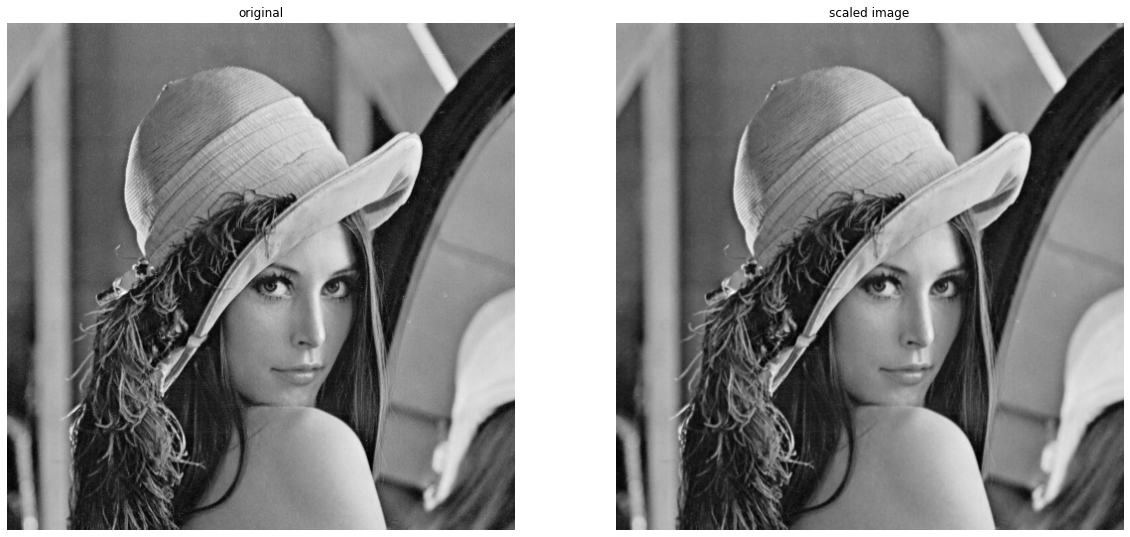

In [8]:
# 3. Design image scaling system
def scaling(img, k):
    h, w = img.shape
    nh = round(h*k)
    nw = round(w*k)
    scaledImg = np.zeros((nh, nw))

    img = np.pad(img, ((0,1),(0,1)), 'symmetric')
    for i in range(nh):     # y
        for j in range(nw): # x
            y = i / k
            x = j / k
            x1, y1 = math.floor(x), math.floor(y)
            x2, y2 = x1 + 1, y1 + 1
            a = x-x1
            b = y-y1
            
            value = (1-a) * ( (1-b)*img[y1,x1] + b*img[y2, x1] ) \
                                + a * ((1-b) * img[y1,x2]  + b*img[y2, x2])
            scaledImg[i][j] = value
    return scaledImg

scaledimg = scaling(img,2)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('original')
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.title('scaled image')
plt.axis('off')
plt.imshow(scaledimg, cmap='gray')

img.shape, scaledimg.shape

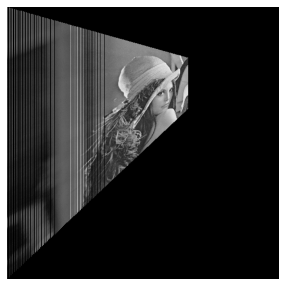

In [6]:
# 4. Design image transform system. 

dof = [[3.56,0,0],
       [1,1,0],
       [0.00852,0,1] ]

def perspectiveT(img, tMat):
    h, w = img.shape
    t_img = np.zeros((h,w))
   
    for i in range(h): # y
        for j in range(w): # x
            point = tMat @ np.transpose([j,i,1])
            y = round(point[1]/point[2])
            x = round(point[0]/point[2])
            t_img[y][x] = img[i][j]
    return t_img

t_img = perspectiveT(img, dof)

plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(t_img,cmap='gray')

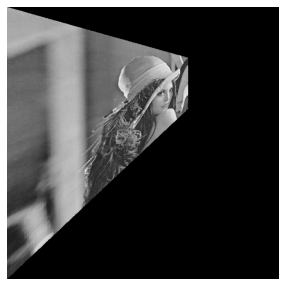

In [7]:
def NNInterpolation(transImg,truthImg, tMat):  #nearest-neighbor (NN) interpolation method
    h, w = transImg.shape
    transImg = np.zeros((h,w))
    
    tMat_inv = np.linalg.inv(tMat)
    for i in range(h): # y
        for j in range(w): # x
            if t_img[i][j]==0:
                point = tMat_inv @ np.transpose([j,i,1])
                y = round(point[1]/point[2])
                x = round(point[0]/point[2])
                if x>=0 and x<w and y>=0 and y<h:
                    t_img[i][j] = img[y][x]   
    return t_img

t_img = NNInterpolation(t_img,img, dof)

plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(t_img,cmap='gray')